<a href="https://colab.research.google.com/github/nshort2001/AAI-510-Project/blob/main/Final_Project_for_ML_Team7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Problem Statement**
The goal of this project is to develop a predictive model for hospital readmissions within 30 days, more than 30 days, and no readmissions. Reducing patient readmissions can significantly improve patient care and reduce healthcare costs.



# **Jusification**
Hospital readmissions are a critical issue in healthcare, leading to increased costs and affecting patient outcomes. By predicting readmissions, hospitals can implement preventive measures, allocate resources more effectively, and improve patient care.

# **Loading and Exploring Raw Data**



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



First few rows of the dataset:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          

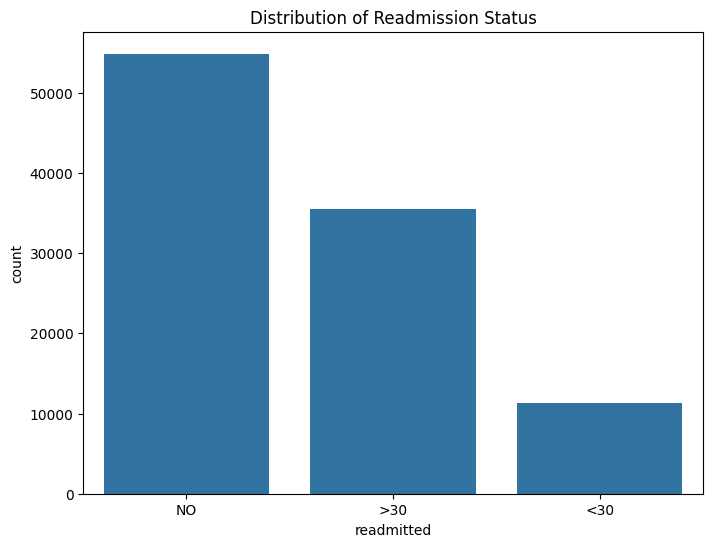

In [ ]:

file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data.csv'
df = pd.read_csv(file_path)

print("First few rows of the dataset:")
print(df.head())
print("\nSummary statistics of the dataset:")
print(df.describe())
print("\nDataset information:")
print(df.info())

print("\nMissing values in the dataset:")
print(df.isnull().sum())

print("\nColumn names in the dataset:")
print(df.columns)

print("\nUnique values in 'readmitted' column:")
print(df['readmitted'].unique())

plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=df)
plt.title('Distribution of Readmission Status')
plt.show()




Unique values in 'readmitted' column:
['NO' '>30' '<30']


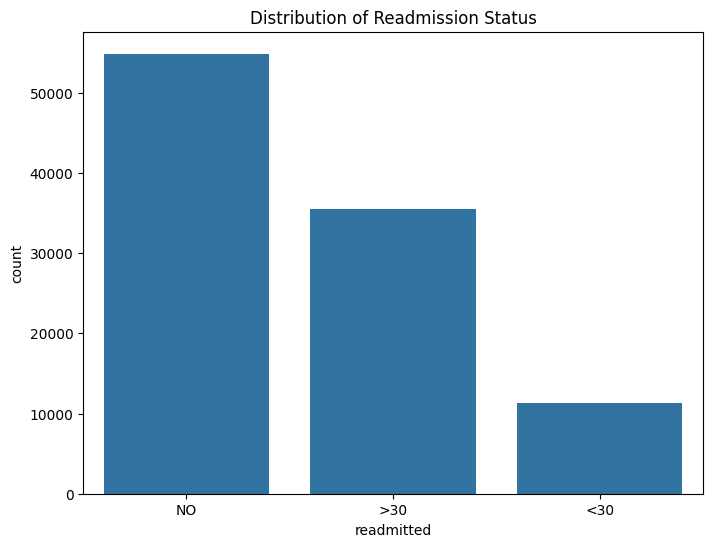

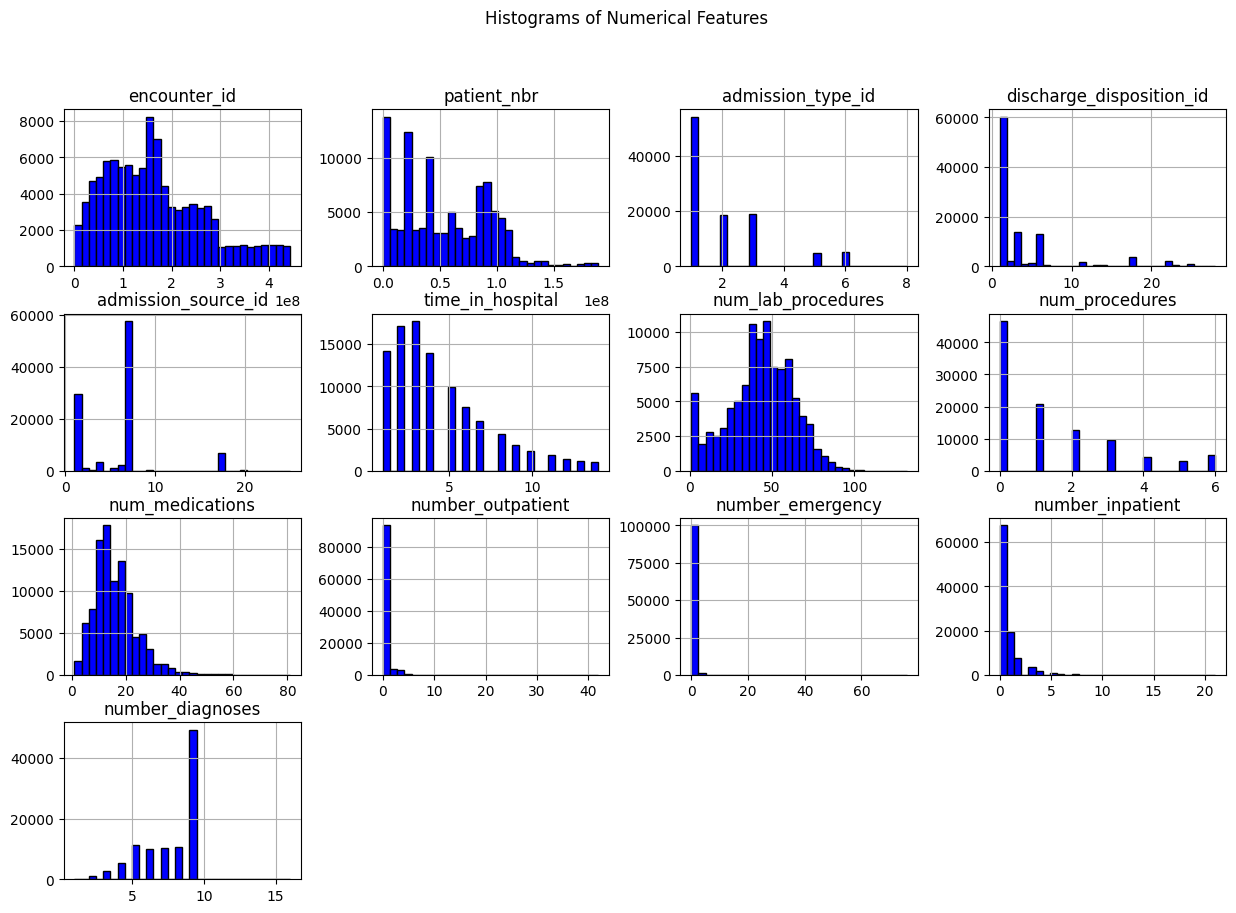

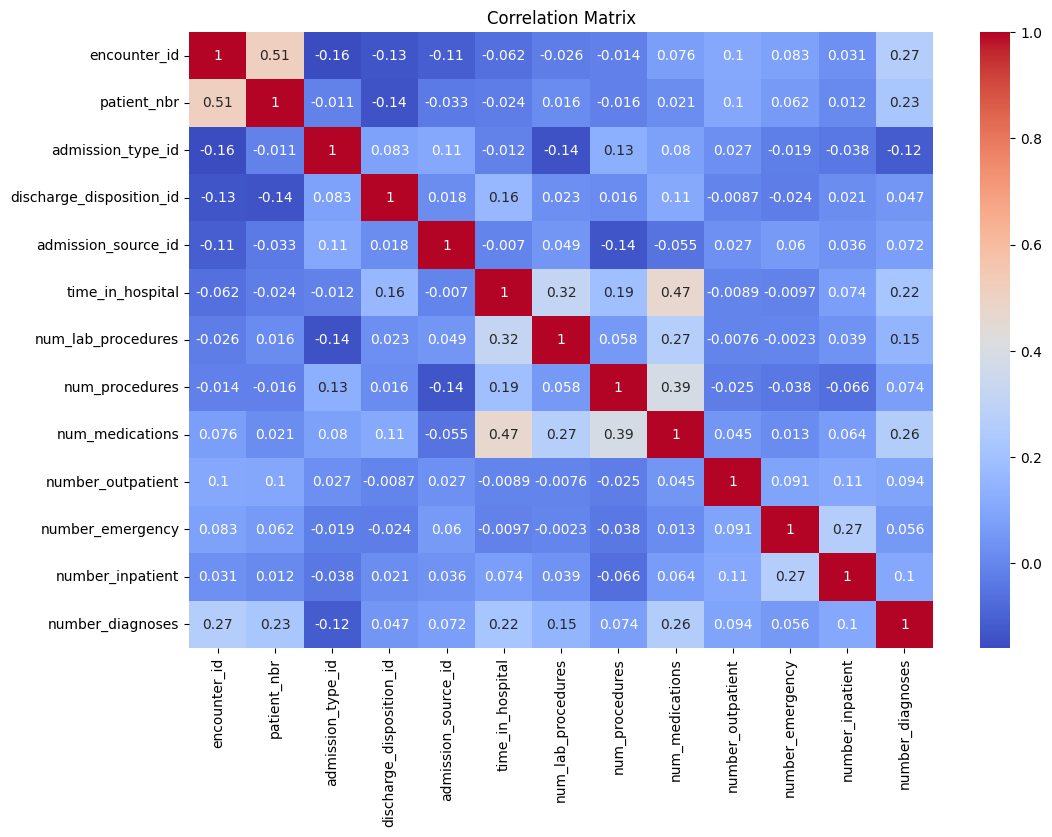

In [ ]:
print("\nUnique values in 'readmitted' column:")
print(df['readmitted'].unique())

plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=df)
plt.title('Distribution of Readmission Status')
plt.show()

df.hist(bins=30, figsize=(15, 10), color='blue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:

print("\nUnique values in 'readmitted' column:")
print(df['readmitted'].unique())

print("\nValue counts for 'readmitted' column:")
print(df['readmitted'].value_counts())



Unique values in 'readmitted' column:
['NO' '>30' '<30']

Value counts for 'readmitted' column:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


# **Data Preparation**
Handle missing values, encode categorical variables, and standardize numerical features.

In [ ]:

file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data.csv'
df = pd.read_csv(file_path)

df.replace('?', np.nan, inplace=True)

print("\nMissing values in the dataset after replacing '?':")
print(df.isnull().sum())

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

cat_cols = df.select_dtypes(include=[object]).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df = pd.get_dummies(df, drop_first=True)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nCleaned dataset information:")
print(df.info())

cleaned_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)

print("Cleaned data saved successfully to:", cleaned_file_path)




Missing values in the dataset after replacing '?':
encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                

# Feature **Engineering**

In [ ]:
Feature Engineering


First few rows with new features:
   encounter_id  patient_nbr  admission_type_id  discharge_disposition_id  \
0     -1.587330    -1.191545           2.750800                  4.031022   
1     -1.608075     0.033564          -0.708461                 -0.514312   
2     -1.608901     0.819654          -0.708461                 -0.514312   
3     -1.604653     0.726480          -0.708461                 -0.514312   
4     -1.609366    -0.305227          -0.708461                 -0.514312   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0            -1.169873         -1.137649           -0.106517       -0.785398   
1             0.306482         -0.467653            0.808384       -0.785398   
2             0.306482         -0.802651           -1.631351        2.145781   
3             0.306482         -0.802651            0.045967       -0.199162   
4             0.306482         -1.137649            0.401761       -0.785398   

   num_medications  n

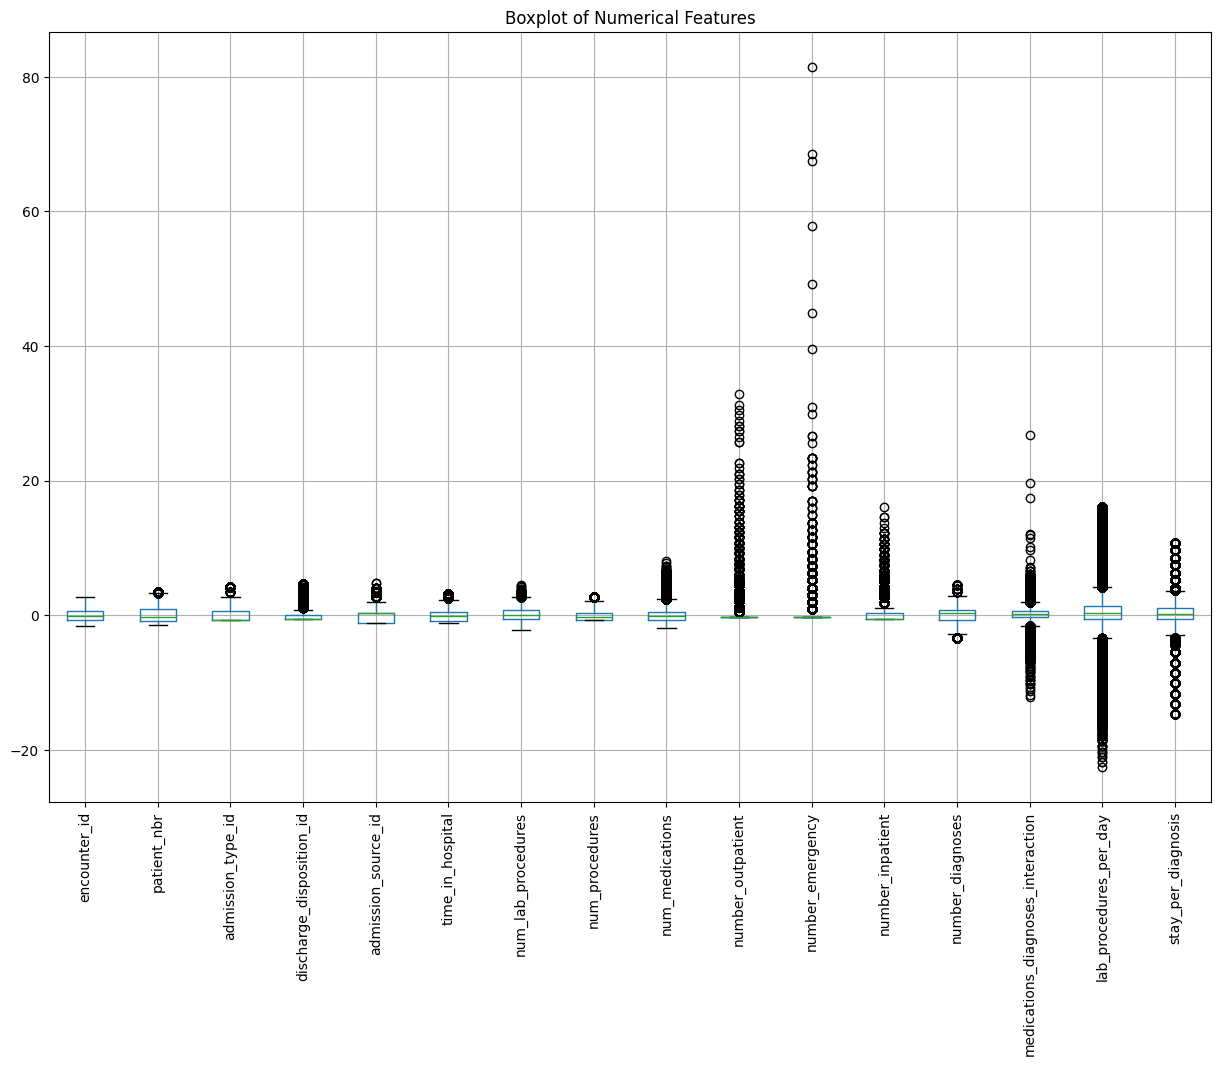


First few rows after handling outliers:
   encounter_id  patient_nbr  admission_type_id  discharge_disposition_id  \
0     -1.534895    -1.191545           2.750800                  4.031022   
1     -1.534895     0.033564          -0.708461                 -0.514312   
2     -1.534895     0.819654          -0.708461                 -0.514312   
3     -1.534895     0.726480          -0.708461                 -0.514312   
4     -1.534895    -0.305227          -0.708461                 -0.514312   

   admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0            -1.169873         -1.137649           -0.106517       -0.785398   
1             0.306482         -0.467653            0.808384       -0.785398   
2             0.306482         -0.802651           -1.631351        2.145781   
3             0.306482         -0.802651            0.045967       -0.199162   
4             0.306482         -1.137649            0.401761       -0.785398   

   num_medicati

In [ ]:

cleaned_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_cleaned.csv'
df = pd.read_csv(cleaned_file_path)

df['medications_diagnoses_interaction'] = df['num_medications'] * df['number_diagnoses']
df['lab_procedures_per_day'] = df['num_lab_procedures'] / df['time_in_hospital']
df['stay_per_diagnosis'] = df['time_in_hospital'] / df['number_diagnoses']

print("\nFirst few rows with new features:")
print(df.head())

numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))
df[numeric_cols].boxplot()
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=90)
plt.show()

for col in numeric_cols:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("\nFirst few rows after handling outliers:")
print(df.head())

enhanced_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_enhanced.csv'
df.to_csv(enhanced_file_path, index=False)

print("Enhanced data saved successfully to:", enhanced_file_path)





# **Feature selection**

In [ ]:

enhanced_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_enhanced.csv'
df = pd.read_csv(enhanced_file_path)

print("Column names in the dataset:")
print(df.columns)

if 'readmitted_<30' in df.columns:
    conditions = [
        (df['readmitted_NO'] == 1),
        (df['readmitted_>30'] == 1),
        (df['readmitted_<30'] == 1)
    ]
    choices = ['NO', '>30', '<30']
    df['readmitted'] = np.select(conditions, choices, default='Unknown')
    df.drop(columns=['readmitted_NO', 'readmitted_>30', 'readmitted_<30'], inplace=True)
else:
    conditions = [
        (df['readmitted_NO'] == 1),
        (df['readmitted_>30'] == 1)
    ]
    choices = ['NO', '>30']
    df['readmitted'] = np.select(conditions, choices, default='<30')
    df.drop(columns=['readmitted_NO', 'readmitted_>30'], inplace=True)

print("\nUnique values in 'readmitted' column:")
print(df['readmitted'].unique())

X = df.drop('readmitted', axis=1)
y = df['readmitted']
y = y.map({'NO': 0, '>30': 1, '<30': 2})

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

print("\nTop 10 features:")
print(feature_importances.head(10))

feature_importances_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/feature_importances.csv'
feature_importances.to_csv(feature_importances_path)

print("Feature importances saved successfully to:", feature_importances_path)



Column names in the dataset:
Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient',
       ...
       'glimepiride-pioglitazone_Steady', 'metformin-rosiglitazone_Steady',
       'metformin-pioglitazone_Steady', 'change_No', 'diabetesMed_Yes',
       'readmitted_>30', 'readmitted_NO', 'medications_diagnoses_interaction',
       'lab_procedures_per_day', 'stay_per_diagnosis'],
      dtype='object', length=2432)

Unique values in 'readmitted' column:
['NO' '>30' '<30']

Top 10 features:
                                   importance
patient_nbr                          0.046533
encounter_id                         0.045479
lab_procedures_per_day               0.037879
num_lab_procedures                   0.036381
medications_diagnoses_interaction    0.035635
num_medications                      0.033796
stay_per_diag

# **Modeling**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), multi_class='ovr')

    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.58, Precision: 0.54, Recall: 0.58, F1-score: 0.54, ROC-AUC: 0.66
Random Forest - Accuracy: 0.59, Precision: 0.58, Recall: 0.59, F1-score: 0.53, ROC-AUC: 0.67
Gradient Boosting - Accuracy: 0.60, Precision: 0.58, Recall: 0.60, F1-score: 0.56, ROC-AUC: 0.69


+----+---------------------+------------+-------------+----------+------------+-----------+
|    | Model               |   Accuracy |   Precision |   Recall |   F1-score |   ROC-AUC |
+====+=====================+============+=============+==========+============+===========+
|  0 | Logistic Regression |       0.58 |        0.54 |     0.58 |       0.54 |      0.66 |
+----+---------------------+------------+-------------+----------+------------+-----------+
|  1 | Random Forest       |       0.59 |        0.58 |     0.59 |       0.53 |      0.67 |
+----+---------------------+------------+-------------+----------+------------+-----------+
|  2 | Gradient Boosting   |       0.6  |        0.58 |     0.6  |       0.56 |      0.69 |
+----+---------------------+------------+-------------+----------+------------+-----------+


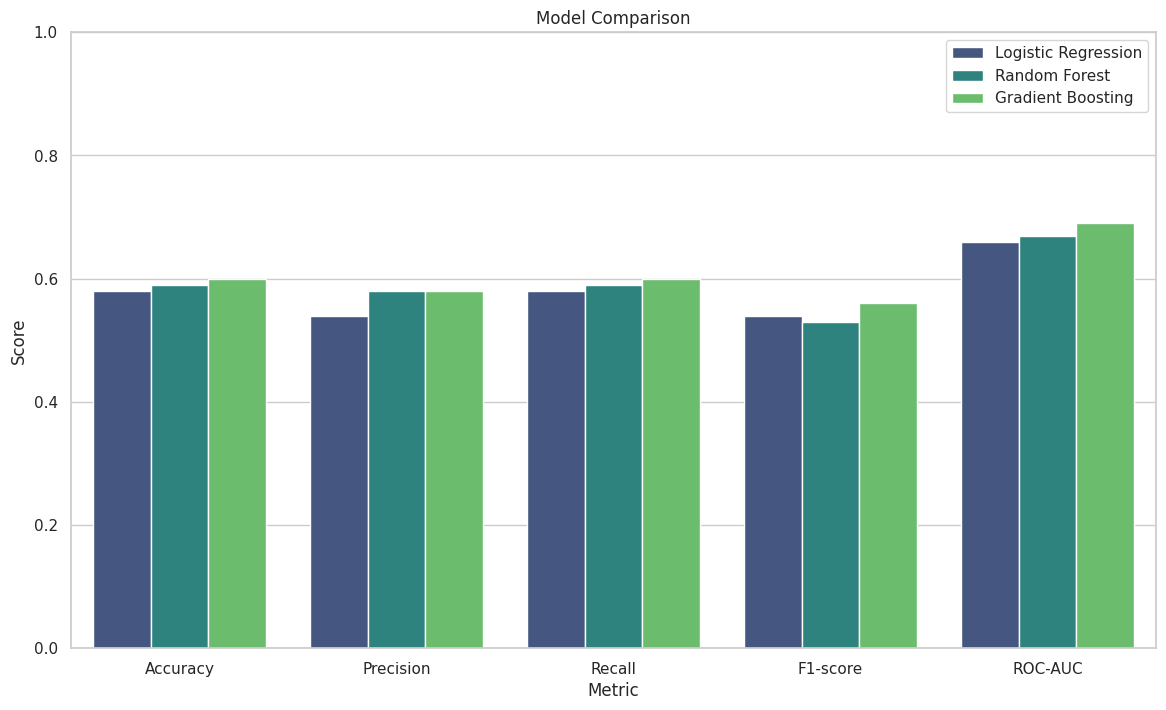

In [ ]:

metrics = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [0.58, 0.59, 0.60],
    "Precision": [0.54, 0.58, 0.58],
    "Recall": [0.58, 0.59, 0.60],
    "F1-score": [0.54, 0.53, 0.56],
    "ROC-AUC": [0.66, 0.67, 0.69]
}

metrics_df = pd.DataFrame(metrics)
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))
sns.set(style="whitegrid")
metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df_melted, palette='viridis')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.show()

Model performnace
The overall performance metrics of the three models  (accuracy, precision, recall, F1-score) suggest that the models are only moderately successful at predicting readmissions. There is still a significant room for improvement
 readmissions.
The Gradient Boosting Classifier emerged as the best performing individual model with an accuracy of 0.60 and a ROC-AUC of 0.69, indicating its capability to handle the complexity and imbalance in the dataset better than other models.


# **Hyperparameter tuning on 1000 subjects **

In [ ]:

enhanced_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_enhanced.csv'
df = pd.read_csv(enhanced_file_path)

conditions = [
    (df['readmitted_NO'] == 1),
    (df['readmitted_>30'] == 1)
]
choices = ['NO', '>30']
df['readmitted'] = np.select(conditions, choices, default='<30')
df.drop(columns=['readmitted_NO', 'readmitted_>30'], inplace=True)

df_sample = df.sample(n=1000, random_state=42)

X_sample = df_sample.drop('readmitted', axis=1)
y_sample = df_sample['readmitted']
y_sample = y_sample.map({'NO': 0, '>30': 1, '<30': 2})

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)

best_params = grid_search.best_params_
print(f"Best parameters for Gradient Boosting: {best_params}")

best_model = grid_search.best_estimator_
y_pred_sample = best_model.predict(X_test_sample)

accuracy = accuracy_score(y_test_sample, y_pred_sample)
precision = precision_score(y_test_sample, y_pred_sample, average='weighted')
recall = recall_score(y_test_sample, y_pred_sample, average='weighted')
f1 = f1_score(y_test_sample, y_pred_sample, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test_sample), best_model.predict_proba(X_test_sample), multi_class='ovr')

print(f"Tuned Gradient Boosting on Sample - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")



Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150}
Tuned Gradient Boosting on Sample - Accuracy: 0.58, Precision: 0.56, Recall: 0.58, F1-score: 0.53, ROC-AUC: 0.64


:# **Ensemble Methods on 1000 subjects ** ***bold text***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

enhanced_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_enhanced.csv'
df = pd.read_csv(enhanced_file_path)

conditions = [
    (df['readmitted_NO'] == 1),
    (df['readmitted_>30'] == 1)
]
choices = ['NO', '>30']
df['readmitted'] = np.select(conditions, choices, default='<30')
df.drop(columns=['readmitted_NO', 'readmitted_>30'], inplace=True)

df_sample = df.sample(n=1000, random_state=42)

X_sample = df_sample.drop('readmitted', axis=1)
y_sample = df_sample['readmitted']
y_sample = y_sample.map({'NO': 0, '>30': 1, '<30': 2})

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
], voting='soft')

ensemble_model.fit(X_train_sample, y_train_sample)
y_pred_sample = ensemble_model.predict(X_test_sample)

accuracy = accuracy_score(y_test_sample, y_pred_sample)
precision = precision_score(y_test_sample, y_pred_sample, average='weighted')
recall = recall_score(y_test_sample, y_pred_sample, average='weighted')
f1 = f1_score(y_test_sample, y_pred_sample, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test_sample), ensemble_model.predict_proba(X_test_sample), multi_class='ovr')

print(f"Ensemble Model on Sample - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")



Ensemble Model on Sample - Accuracy: 0.58, Precision: 0.52, Recall: 0.58, F1-score: 0.55, ROC-AUC: 0.65


# ***Solution to class Imbalance ***

In [13]:

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sample, y_train_sample)

print("Original training set shape:", X_train_sample.shape)
print("Resampled training set shape:", X_train_resampled.shape)


Original training set shape: (800, 2430)
Resampled training set shape: (1272, 2430)


# ***Code for deployment into Electronic health records ***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
from flask import Flask, request, jsonify

enhanced_file_path = '/content/drive/MyDrive/Hospital Readmission-prediction-ML Project/diabetic_data_enhanced.csv'
df = pd.read_csv(enhanced_file_path)

conditions = [
    (df['readmitted_NO'] == 1),
    (df['readmitted_>30'] == 1)
]
choices = ['NO', '>30']
df['readmitted'] = np.select(conditions, choices, default='<30')
df.drop(columns=['readmitted_NO', 'readmitted_>30'], inplace=True)

df_sample = df.sample(n=1000, random_state=42)

X_sample = df_sample.drop('readmitted', axis=1)
y_sample = df_sample['readmitted']
y_sample = y_sample.map({'NO': 0, '>30': 1, '<30': 2})

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'diabetic_readmission_model.pkl')

app = Flask(__name__)
model = joblib.load('diabetic_readmission_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    features = np.array(data['features']).reshape(1, -1)
    prediction = model.predict(features)
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)

accuracy = accuracy_score(y_test_sample, model.predict(X_test_sample))
precision = precision_score(y_test_sample, model.predict(X_test_sample), average='weighted')
recall = recall_score(y_test_sample, model.predict(X_test_sample), average='weighted')
f1 = f1_score(y_test_sample, model.predict(X_test_sample), average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test_sample), model.predict_proba(X_test_sample), multi_class='ovr')

print(f"Tuned Gradient Boosting on Sample - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")
